In [ ]:
#importamos librerias necesarias para la manipulación
#A FAVOR ES 1
import pandas as pd
import numpy as np

In [ ]:
# Prerequisite: Installs the latest version of Ludwig in the Colab environment

%pip install ludwig --quiet
%pip install ludwig[viz] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 15.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.0/232.0 kB 29.1 MB/s eta 0:00:00


In [ ]:
#Cargamos base de datos en formato CSV
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_excel('/content/drive/MyDrive/BD_MAYO_2.xlsx', engine='openpyxl')

In [ ]:
df = df[(df['REGIONAL'] == 'CALI')]
# & (~df['RESUELVE'].str.contains('hecho superado', case=False))]


#Columnas_deseadas= ['PRETE','RESULTADO']
Columnas_deseadas= ['PRETE','COBERTURA']
df=df[Columnas_deseadas]
print(df.head())

                                                PRETE  COBERTURA
65  Que se me autorice la atención integral para m...          0
66  Sea concedido el amparo constitucional via acc...          0
78  Con base en lo anterior, solicito respetuosame...          0
79  2.1. POR MEDIO DE ESTA TUTELA, SOLICITO ME SEA...          0
83  1. SÍRVASE SEÑOR JUEZ A ORDENAR ALA EPS SANITA...          0


In [ ]:
# Para contar cuántas veces aparece cada valor en la columna CATEGORIA
conteo = df['COBERTURA'].value_counts()
#conteo = df['RESULTADO'].value_counts()
print(conteo)

COBERTURA
0    724
1    529
Name: count, dtype: int64


In [ ]:
#Token Hugging face acceso
import getpass
#import locale; locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
import logging
import os

from ludwig.api import LudwigModel


os.environ["HUGGING_FACE_HUB_TOKEN"] = getpass.getpass("Token:")
assert os.environ["HUGGING_FACE_HUB_TOKEN"]

Token:··········


In [ ]:
import logging
from ludwig.api import LudwigModel

# Configuración ajustada
config = {
    "input_features": [
        {
            "name": "PRETE",
            "type": "text",
            "preprocessing": {"tokenizer":"hf_tokenizer", "cache_encoder_embeddings": True},
            "encoder": {
                "type": "auto_transformer",
                "pretrained_model_name_or_path": "dccuchile/bert-base-spanish-wwm-uncased",
                "trainable": True,
                "regularizer": {
                    "type": "l2",
                    "weight": 0.01  # 0.01 Regularización L2 aplicada al encoder
                }
            }
        },
    ],
    "output_features": [
        {
            "name": "COBERTURA",
            "type": "binary",
            "calibration": True
        }
    ],
    "preprocessing": {
        "oversample_minority": 0.5
    },
    "adapter": {
        "type": "adalora",
        "r": 8,
        "dropout": 0.05,
        "target_modules": None,
        "use_rslora": False,
        "use_dora": False,
        "alpha": 16,
        "pretrained_adapter_weights": None,
        "postprocessor": {
            "merge_adapter_into_base_model": False,
            "progressbar": False
        },
        "bias_type": "none",
        "target_r": 8,
        "init_r": 12,
        "tinit": 0,
        "tfinal": 0,
        "delta_t": 1,
        "beta1": 0.85,
        "beta2": 0.85,
        "orth_reg_weight": 0.5,
        "total_step": None,
        "rank_pattern": None
    },
    "trainer": {
        "epochs": 55,
        "learning_rate": 0.0001,
        "optimizer": {"type": "adam"},
        "batch_size": 64,
        "early_stop": 40,

    }
}


In [ ]:
# Crea una instancia del modelo Ludwig con la configuración
model = LudwigModel(config, logging_level=logging.INFO)

In [ ]:
train_stats,pred,out = model.train(dataset=df)

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run_2                                                   │
├──────────────────┼─────────────────────────────────────────────────────────────────

Training:   2%|▏         | 12/660 [00:07<06:13,  1.74it/s, loss=15.4]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 12, epoch: 1


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1477s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤══════════╤══════════════╤═════════╕
│               │    train │   validation │    test │
╞═══════════════╪══════════╪══════════════╪═════════╡
│ accuracy      │   0.5397 │       0.4080 │  0.4160 │
├───────────────┼──────────┼──────────────┼─────────┤
│ loss          │ 190.0055 │      83.3087 │ 86.7129 │
├───────────────┼──────────┼──────────────┼─────────┤
│ precision     │   0.3182 │       0.4080 │  0.4160 │
├───────────────┼──────────┼──────────────┼─────────┤
│ recall        │   0.3333 │       1.0000 │  1.0000 │
├───────────────┼──────────┼──────────────┼─────────┤
│ roc_auc       │   0.4813 │       0.5000 │  0.5000 │
├───────────────┼──────────┼──────────────┼─────────┤
│ specificity   │   0.6429 │       0.0000 │  0.0000 │
├───────────────┼──────────┼──────────────┼─────────┤
│ combined_loss │ 190.0055 │      83.3087 │ 86.7129 │
╘═══════════════╧══════════╧══════════════


Training:   4%|▎         | 24/660 [00:24<06:41,  1.58it/s, loss=21.3]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 24, epoch: 2


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1493s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.5198 │       0.6400 │  0.5520 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │ 43.8012 │      20.1801 │ 29.8424 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.3520 │       0.5469 │  0.4750 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.5238 │       0.6863 │  0.7308 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.5598 │       0.6766 │  0.5781 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.5179 │       0.6081 │  0.4247 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │ 43.8012 │      20.1801 │ 29.8424 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:   5%|▌         | 36/660 [00:43<06:43,  1.55it/s, loss=9.15]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 36, epoch: 3


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1490s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.6323 │       0.7840 │  0.6640 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │ 19.4080 │       5.8877 │ 10.2163 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.4526 │       0.7069 │  0.5781 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.4921 │       0.8039 │  0.7115 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.6486 │       0.8325 │  0.6903 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.7024 │       0.7703 │  0.6301 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │ 19.4080 │       5.8877 │ 10.2163 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:   7%|▋         | 48/660 [01:03<06:41,  1.53it/s, loss=3.32]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 48, epoch: 4


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1448s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.6931 │       0.6720 │  0.5640 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │ 11.4160 │      12.9772 │ 18.4938 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.5397 │       0.5556 │  0.4870 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.5397 │       0.9804 │  0.9038 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.7367 │       0.7599 │  0.6508 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.7698 │       0.4595 │  0.3219 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │ 11.4160 │      12.9772 │ 18.4938 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:   9%|▉         | 60/660 [01:20<06:19,  1.58it/s, loss=1.49]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 60, epoch: 5


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1474s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.7923 │       0.6400 │  0.5440 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  6.5568 │      11.8652 │ 16.4656 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.6632 │       0.5312 │  0.4755 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.7659 │       1.0000 │  0.9327 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.8713 │       0.7540 │  0.6682 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.8056 │       0.3919 │  0.2671 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  6.5568 │      11.8652 │ 16.4656 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  11%|█         | 72/660 [01:33<05:59,  1.64it/s, loss=0.25]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 72, epoch: 6


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1484s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.7857 │       0.6400 │  0.6000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  7.9762 │      18.9900 │ 23.2305 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.6490 │       0.8750 │  1.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.7778 │       0.1373 │  0.0385 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.8301 │       0.8364 │  0.7769 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.7897 │       0.9865 │  1.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  7.9762 │      18.9900 │ 23.2305 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  13%|█▎        | 84/660 [01:52<06:12,  1.54it/s, loss=20.6]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 84, epoch: 7


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1488s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.7315 │       0.7600 │  0.7160 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  8.3795 │       8.1333 │ 10.9102 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.6034 │       0.8000 │  0.7619 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.5675 │       0.5490 │  0.4615 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.8015 │       0.8471 │  0.7960 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.8135 │       0.9054 │  0.8973 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  8.3795 │       8.1333 │ 10.9102 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  15%|█▍        | 96/660 [02:11<06:03,  1.55it/s, loss=15.9]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 96, epoch: 8


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1471s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.8333 │       0.8080 │  0.7480 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  6.7211 │       7.2494 │ 10.6009 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.7582 │       0.7213 │  0.6694 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.7341 │       0.8627 │  0.7788 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.8995 │       0.8723 │  0.7977 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.8829 │       0.7703 │  0.7260 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  6.7211 │       7.2494 │ 10.6009 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  16%|█▋        | 108/660 [02:30<06:03,  1.52it/s, loss=0.309]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 108, epoch: 9


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1474s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9167 │       0.6240 │  0.5880 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  2.2236 │      16.5218 │ 18.6607 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9276 │       0.5208 │  0.5026 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.8135 │       0.9804 │  0.9423 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9713 │       0.7358 │  0.7084 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9683 │       0.3784 │  0.3356 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  2.2236 │      16.5218 │ 18.6607 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  18%|█▊        | 120/660 [02:43<05:30,  1.64it/s, loss=2.23]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 120, epoch: 10


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1489s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.8280 │       0.7680 │  0.7080 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  5.3632 │      15.6256 │ 23.0163 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.7148 │       0.8929 │  0.7818 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.8056 │       0.4902 │  0.4135 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9014 │       0.8655 │  0.8051 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.8393 │       0.9595 │  0.9178 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  5.3632 │      15.6256 │ 23.0163 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  20%|██        | 132/660 [02:56<05:22,  1.63it/s, loss=16]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 132, epoch: 11


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1506s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.8651 │       0.7280 │  0.7320 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  6.6305 │      17.4878 │ 26.6781 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.8099 │       0.6133 │  0.6259 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.7778 │       0.9020 │  0.8846 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9298 │       0.7944 │  0.7826 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9087 │       0.6081 │  0.6233 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  6.6305 │      17.4878 │ 26.6781 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  22%|██▏       | 144/660 [03:09<05:15,  1.64it/s, loss=0.698]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 144, epoch: 12


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1514s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9206 │       0.7120 │  0.6800 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  4.7336 │      22.6225 │ 27.3963 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.8934 │       0.8947 │  0.9286 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.8651 │       0.3333 │  0.2500 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9554 │       0.7973 │  0.7839 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9484 │       0.9730 │  0.9863 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  4.7336 │      22.6225 │ 27.3963 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  24%|██▎       | 156/660 [03:23<05:07,  1.64it/s, loss=2.26]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 156, epoch: 13


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1480s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │   validation │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.9140 │       0.8240 │ 0.7920 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  3.1648 │       7.5214 │ 9.9970 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.8528 │       0.7959 │ 0.7549 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.8968 │       0.7647 │ 0.7404 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.9558 │       0.8831 │ 0.8337 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  0.9226 │       0.8649 │ 0.8288 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  3.1648 │       7.5214 │ 9.9970 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  25%|██▌       | 168/660 [03:42<05:52,  1.40it/s, loss=1.29]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 168, epoch: 14


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1486s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9709 │       0.8320 │  0.7840 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.9152 │      10.0222 │ 14.4036 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9457 │       0.8409 │  0.7841 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9683 │       0.7255 │  0.6635 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9890 │       0.8691 │  0.8192 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9722 │       0.9054 │  0.8699 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.9152 │      10.0222 │ 14.4036 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  27%|██▋       | 180/660 [03:55<04:53,  1.64it/s, loss=0.416]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 180, epoch: 15


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1488s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9563 │       0.8160 │  0.7840 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  1.7535 │       9.1513 │ 11.1874 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9544 │       0.8043 │  0.7500 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9127 │       0.7255 │  0.7212 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9826 │       0.8732 │  0.8284 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9782 │       0.8784 │  0.8288 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  1.7535 │       9.1513 │ 11.1874 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  29%|██▉       | 192/660 [04:10<04:49,  1.61it/s, loss=8.94e-8]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 192, epoch: 16


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1493s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9563 │       0.8400 │  0.8040 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  1.3020 │      11.6658 │ 18.9834 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9620 │       0.8605 │  0.7957 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9048 │       0.7255 │  0.7115 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9898 │       0.8764 │  0.8399 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9821 │       0.9189 │  0.8699 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  1.3020 │      11.6658 │ 18.9834 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  31%|███       | 204/660 [04:23<04:38,  1.64it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 204, epoch: 17


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1497s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9815 │       0.8160 │  0.7840 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.3463 │      13.6909 │ 20.1106 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9798 │       0.7800 │  0.7841 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9643 │       0.7647 │  0.6635 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9974 │       0.8686 │  0.8109 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9901 │       0.8514 │  0.8699 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.3463 │      13.6909 │ 20.1106 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  33%|███▎      | 216/660 [04:40<04:42,  1.57it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 216, epoch: 18


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1475s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9696 │       0.8240 │  0.7320 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  1.4418 │      30.2420 │ 48.8966 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9636 │       1.0000 │  0.9302 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9444 │       0.5686 │  0.3846 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9872 │       0.8323 │  0.7313 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9821 │       1.0000 │  0.9795 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  1.4418 │      30.2420 │ 48.8966 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  35%|███▍      | 228/660 [04:55<04:26,  1.62it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 228, epoch: 19


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1483s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9497 │       0.8720 │  0.7840 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  1.4724 │      11.0943 │ 20.8443 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9315 │       0.7966 │  0.7155 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9167 │       0.9216 │  0.7981 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9844 │       0.9074 │  0.8321 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9663 │       0.8378 │  0.7740 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  1.4724 │      11.0943 │ 20.8443 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  36%|███▋      | 240/660 [05:12<04:26,  1.57it/s, loss=6.9]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 240, epoch: 20


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1477s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9815 │       0.8400 │  0.7360 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  1.1525 │      25.1952 │ 28.0418 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9612 │       0.7719 │  0.7209 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9841 │       0.8627 │  0.5962 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9910 │       0.8704 │  0.7804 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9802 │       0.8243 │  0.8356 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  1.1525 │      25.1952 │ 28.0418 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  38%|███▊      | 252/660 [05:25<04:09,  1.64it/s, loss=4.06]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 252, epoch: 21


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1528s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9802 │       0.7040 │  0.6880 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.9888 │      23.9418 │ 34.5172 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9837 │       0.8889 │  0.9062 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9563 │       0.3137 │  0.2788 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9934 │       0.8408 │  0.7480 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9921 │       0.9730 │  0.9795 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.9888 │      23.9418 │ 34.5172 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  40%|████      | 264/660 [05:41<04:07,  1.60it/s, loss=0.376]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 264, epoch: 22


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1456s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.8823 │       0.7200 │  0.7040 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  6.9427 │      54.1807 │ 67.4009 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.8528 │       1.0000 │  0.9167 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.7817 │       0.3137 │  0.3173 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9133 │       0.7599 │  0.7019 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9325 │       1.0000 │  0.9795 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  6.9427 │      54.1807 │ 67.4009 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  42%|████▏     | 276/660 [05:54<03:54,  1.63it/s, loss=1.4]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 276, epoch: 23


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1480s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9683 │       0.8640 │  0.7680 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  2.0180 │      23.1683 │ 46.4968 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9831 │       0.9250 │  0.8194 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9206 │       0.7255 │  0.5673 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9826 │       0.8880 │  0.7861 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9921 │       0.9595 │  0.9110 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  2.0180 │      23.1683 │ 46.4968 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  44%|████▎     | 288/660 [06:10<03:52,  1.60it/s, loss=6.12e-7]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 288, epoch: 24


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1511s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9894 │       0.8000 │  0.7360 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.4873 │      25.9312 │ 45.0285 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9803 │       0.9333 │  0.8800 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9881 │       0.5490 │  0.4231 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9958 │       0.8263 │  0.7475 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9901 │       0.9730 │  0.9589 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.4873 │      25.9312 │ 45.0285 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  45%|████▌     | 300/660 [06:24<03:41,  1.63it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 300, epoch: 25


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1452s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9894 │       0.8480 │  0.7400 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.2925 │      19.9228 │ 38.4966 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9841 │       0.9211 │  0.8545 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9841 │       0.6863 │  0.4519 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9958 │       0.8818 │  0.7729 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9921 │       0.9595 │  0.9452 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.2925 │      19.9228 │ 38.4966 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  47%|████▋     | 312/660 [06:37<03:32,  1.64it/s, loss=1.28]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 312, epoch: 26


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1464s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9894 │       0.7440 │  0.7040 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.3645 │      30.6220 │ 50.5185 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9766 │       0.8800 │  0.9167 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9921 │       0.4314 │  0.3173 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9949 │       0.8207 │  0.7003 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9881 │       0.9595 │  0.9795 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.3645 │      30.6220 │ 50.5185 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  49%|████▉     | 324/660 [06:50<03:25,  1.63it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 324, epoch: 27


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1473s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9828 │       0.7040 │  0.6800 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.8664 │      45.7332 │ 64.8640 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9799 │       0.9375 │  0.9286 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9683 │       0.2941 │  0.2500 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9913 │       0.7822 │  0.6852 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9901 │       0.9865 │  0.9863 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.8664 │      45.7332 │ 64.8640 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  51%|█████     | 336/660 [07:04<03:17,  1.64it/s, loss=0.0718]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 336, epoch: 28


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1498s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9788 │       0.8320 │  0.7600 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.9047 │      23.3751 │ 37.5316 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9683 │       0.9167 │  0.8929 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9683 │       0.6471 │  0.4808 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9927 │       0.8449 │  0.7909 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9841 │       0.9595 │  0.9589 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.9047 │      23.3751 │ 37.5316 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  53%|█████▎    | 348/660 [07:20<03:17,  1.58it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 348, epoch: 29


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1512s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9907 │       0.8160 │  0.7600 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.3213 │      20.8778 │ 27.1312 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9880 │       0.7917 │  0.7340 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9841 │       0.7451 │  0.6635 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9969 │       0.8200 │  0.7950 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9940 │       0.8649 │  0.8288 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.3213 │      20.8778 │ 27.1312 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  55%|█████▍    | 360/660 [07:33<03:03,  1.64it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 360, epoch: 30


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1515s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9894 │       0.8400 │  0.7560 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.2980 │      21.3364 │ 37.4624 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9841 │       0.9189 │  0.8772 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9841 │       0.6667 │  0.4808 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9959 │       0.8653 │  0.7793 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9921 │       0.9595 │  0.9521 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.2980 │      21.3364 │ 37.4624 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  56%|█████▋    | 372/660 [07:50<03:01,  1.59it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 372, epoch: 31


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1467s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤══════════╕
│               │   train │   validation │     test │
╞═══════════════╪═════════╪══════════════╪══════════╡
│ accuracy      │  0.9947 │       0.6880 │   0.6440 │
├───────────────┼─────────┼──────────────┼──────────┤
│ loss          │  0.1384 │      75.9226 │ 110.8053 │
├───────────────┼─────────┼──────────────┼──────────┤
│ precision     │  0.9844 │       1.0000 │   0.8947 │
├───────────────┼─────────┼──────────────┼──────────┤
│ recall        │  1.0000 │       0.2353 │   0.1635 │
├───────────────┼─────────┼──────────────┼──────────┤
│ roc_auc       │  0.9980 │       0.7353 │   0.6433 │
├───────────────┼─────────┼──────────────┼──────────┤
│ specificity   │  0.9921 │       1.0000 │   0.9863 │
├───────────────┼─────────┼──────────────┼──────────┤
│ combined_loss │  0.1384 │      75.9226 │ 110.8053 │
╘═══════════════╧═════════╧══════════════╧


Training:  58%|█████▊    | 384/660 [08:03<02:48,  1.64it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 384, epoch: 32


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1467s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9881 │       0.8320 │  0.7360 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.4507 │      43.5915 │ 73.9533 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9880 │       0.9688 │  0.8393 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9762 │       0.6078 │  0.4519 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9969 │       0.8229 │  0.7535 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9940 │       0.9865 │  0.9384 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.4507 │      43.5915 │ 73.9533 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  60%|██████    | 396/660 [08:20<02:47,  1.58it/s, loss=4.4]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 396, epoch: 33


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1497s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9854 │       0.6640 │  0.6640 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.8300 │      65.0582 │ 84.4777 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9879 │       1.0000 │  0.9167 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9683 │       0.1765 │  0.2115 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9928 │       0.7157 │  0.6619 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9940 │       1.0000 │  0.9863 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.8300 │      65.0582 │ 84.4777 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  62%|██████▏   | 408/660 [08:33<02:33,  1.64it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 408, epoch: 34


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1483s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9854 │       0.8080 │  0.7240 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.8150 │      24.9699 │ 40.8784 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9879 │       0.9091 │  0.7869 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9683 │       0.5882 │  0.4615 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9927 │       0.8678 │  0.7806 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9940 │       0.9595 │  0.9110 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.8150 │      24.9699 │ 40.8784 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  64%|██████▎   | 420/660 [08:51<02:32,  1.57it/s, loss=0.000383]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 420, epoch: 35


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1487s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9934 │       0.8240 │  0.7280 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.1240 │      32.2444 │ 49.0248 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9881 │       0.9394 │  0.8000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9921 │       0.6078 │  0.4615 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9989 │       0.8389 │  0.7468 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9940 │       0.9730 │  0.9178 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.1240 │      32.2444 │ 49.0248 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  65%|██████▌   | 432/660 [09:04<02:19,  1.63it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 432, epoch: 36


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1466s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9947 │       0.7360 │  0.6880 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.2430 │      37.9723 │ 59.8104 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9921 │       0.9500 │  0.9062 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9921 │       0.3725 │  0.2788 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9979 │       0.8095 │  0.7083 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9960 │       0.9865 │  0.9795 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.2430 │      37.9723 │ 59.8104 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  67%|██████▋   | 444/660 [09:20<02:15,  1.59it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 444, epoch: 37


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1483s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9934 │       0.8080 │  0.7360 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.1568 │      44.4136 │ 76.1239 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9960 │       0.8857 │  0.8654 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9841 │       0.6078 │  0.4327 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9999 │       0.8168 │  0.7577 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9980 │       0.9459 │  0.9521 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.1568 │      44.4136 │ 76.1239 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  69%|██████▉   | 456/660 [09:33<02:04,  1.64it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 456, epoch: 38


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1451s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9894 │       0.8240 │  0.7560 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.8721 │      32.3523 │ 53.3876 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9841 │       0.9143 │  0.8772 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9841 │       0.6275 │  0.4808 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9929 │       0.8727 │  0.7716 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9921 │       0.9595 │  0.9521 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.8721 │      32.3523 │ 53.3876 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  71%|███████   | 468/660 [09:50<02:01,  1.58it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 468, epoch: 39


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1477s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9894 │       0.7520 │  0.6600 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.2387 │      61.9144 │ 88.6360 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9766 │       1.0000 │  0.8800 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9921 │       0.3922 │  0.2115 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9969 │       0.7605 │  0.6791 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9881 │       1.0000 │  0.9795 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.2387 │      61.9144 │ 88.6360 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  73%|███████▎  | 480/660 [10:04<01:49,  1.64it/s, loss=3.99e-5]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 480, epoch: 40


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1479s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9775 │       0.7200 │  0.6560 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  1.4711 │      51.0819 │ 63.8803 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9572 │       1.0000 │  0.9500 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9762 │       0.3137 │  0.1827 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9853 │       0.7801 │  0.7014 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9782 │       1.0000 │  0.9932 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  1.4711 │      51.0819 │ 63.8803 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  75%|███████▍  | 492/660 [10:20<01:46,  1.58it/s, loss=0.000229]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 492, epoch: 41


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1507s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9907 │       0.8000 │  0.7280 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.2717 │      66.8707 │ 92.6250 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9842 │       1.0000 │  0.9286 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9881 │       0.5098 │  0.3750 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9969 │       0.7684 │  0.7071 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9921 │       1.0000 │  0.9795 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.2717 │      66.8707 │ 92.6250 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  76%|███████▋  | 504/660 [10:34<01:35,  1.64it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 504, epoch: 42


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1459s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9960 │       0.8480 │  0.8200 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.3034 │      28.9299 │ 46.3555 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9960 │       0.8478 │  0.8172 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9921 │       0.7647 │  0.7308 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9989 │       0.8757 │  0.8299 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9980 │       0.9054 │  0.8836 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.3034 │      28.9299 │ 46.3555 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  78%|███████▊  | 516/660 [10:50<01:30,  1.58it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 516, epoch: 43


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1477s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  1.0000 │       0.8320 │  0.7680 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.0000 │      36.1702 │ 56.0813 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  1.0000 │       0.8750 │  0.8108 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  1.0000 │       0.6863 │  0.5769 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  1.0000 │       0.8331 │  0.7803 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  1.0000 │       0.9324 │  0.9041 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.0000 │      36.1702 │ 56.0813 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  80%|████████  | 528/660 [11:03<01:20,  1.64it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 528, epoch: 44


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1488s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  1.0000 │       0.8160 │  0.7680 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.0000 │      40.0827 │ 59.9142 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  1.0000 │       0.8684 │  0.8286 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  1.0000 │       0.6471 │  0.5577 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  1.0000 │       0.8324 │  0.7738 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  1.0000 │       0.9324 │  0.9178 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.0000 │      40.0827 │ 59.9142 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  82%|████████▏ | 540/660 [11:21<01:16,  1.57it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 540, epoch: 45


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1490s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9987 │       0.8800 │  0.8080 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.0016 │      27.0589 │ 42.1472 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  1.0000 │       0.8600 │  0.7800 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9960 │       0.8431 │  0.7500 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  1.0000 │       0.8792 │  0.8357 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  1.0000 │       0.9054 │  0.8493 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.0016 │      27.0589 │ 42.1472 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  84%|████████▎ | 552/660 [11:34<01:05,  1.64it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 552, epoch: 46


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1492s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9947 │       0.8000 │  0.7760 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.2907 │      37.3360 │ 60.9703 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9921 │       0.8824 │  0.8529 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9921 │       0.5882 │  0.5577 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9960 │       0.8425 │  0.7580 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9960 │       0.9459 │  0.9315 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.2907 │      37.3360 │ 60.9703 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  85%|████████▌ | 564/660 [11:50<01:00,  1.59it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 564, epoch: 47


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1470s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9987 │       0.7200 │  0.7000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.0863 │      65.1443 │ 94.0141 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9960 │       0.9000 │  0.8919 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  1.0000 │       0.3529 │  0.3173 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9990 │       0.7562 │  0.6835 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9980 │       0.9730 │  0.9726 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.0863 │      65.1443 │ 94.0141 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  87%|████████▋ | 576/660 [12:05<00:52,  1.61it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 576, epoch: 48


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1443s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9934 │       0.7920 │  0.7040 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.1918 │      71.8489 │ 93.3321 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9881 │       1.0000 │  0.8750 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9921 │       0.4902 │  0.3365 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9979 │       0.7785 │  0.7009 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9940 │       1.0000 │  0.9658 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.1918 │      71.8489 │ 93.3321 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  89%|████████▉ | 588/660 [12:20<00:44,  1.62it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 588, epoch: 49


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1429s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9868 │       0.7040 │  0.6800 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  1.2921 │      69.3338 │ 91.0244 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9879 │       1.0000 │  0.9286 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9722 │       0.2745 │  0.2500 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9890 │       0.7549 │  0.6792 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9940 │       1.0000 │  0.9863 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  1.2921 │      69.3338 │ 91.0244 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  91%|█████████ | 600/660 [12:34<00:36,  1.63it/s, loss=0.725]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 600, epoch: 50


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1431s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9802 │       0.7760 │  0.7400 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.8304 │      61.3174 │ 97.6277 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9798 │       0.9600 │  0.9149 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9603 │       0.4706 │  0.4135 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9954 │       0.8014 │  0.7282 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9901 │       0.9865 │  0.9726 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.8304 │      61.3174 │ 97.6277 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  93%|█████████▎| 612/660 [12:50<00:30,  1.58it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 612, epoch: 51


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1520s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤══════════╕
│               │   train │   validation │     test │
╞═══════════════╪═════════╪══════════════╪══════════╡
│ accuracy      │  0.9947 │       0.7840 │   0.7200 │
├───────────────┼─────────┼──────────────┼──────────┤
│ loss          │  0.3334 │      68.4578 │ 112.8081 │
├───────────────┼─────────┼──────────────┼──────────┤
│ precision     │  0.9921 │       0.9286 │   0.8542 │
├───────────────┼─────────┼──────────────┼──────────┤
│ recall        │  0.9921 │       0.5098 │   0.3942 │
├───────────────┼─────────┼──────────────┼──────────┤
│ roc_auc       │  0.9980 │       0.7819 │   0.7076 │
├───────────────┼─────────┼──────────────┼──────────┤
│ specificity   │  0.9960 │       0.9730 │   0.9521 │
├───────────────┼─────────┼──────────────┼──────────┤
│ combined_loss │  0.3334 │      68.4578 │ 112.8081 │
╘═══════════════╧═════════╧══════════════╧


Training:  95%|█████████▍| 624/660 [13:03<00:21,  1.64it/s, loss=1.21e-6]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 624, epoch: 52


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1462s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9974 │       0.8240 │  0.7480 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.2425 │      43.5739 │ 73.4636 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9960 │       0.9143 │  0.8254 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9960 │       0.6275 │  0.5000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9990 │       0.8255 │  0.7542 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9980 │       0.9595 │  0.9247 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.2425 │      43.5739 │ 73.4636 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  96%|█████████▋| 636/660 [13:20<00:15,  1.58it/s, loss=2.91]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 636, epoch: 53


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1480s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9947 │       0.8800 │  0.8040 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.5305 │      22.3848 │ 39.2841 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9960 │       0.8462 │  0.7957 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9881 │       0.8627 │  0.7115 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9950 │       0.8853 │  0.8223 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9980 │       0.8919 │  0.8699 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.5305 │      22.3848 │ 39.2841 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  98%|█████████▊| 648/660 [13:33<00:07,  1.64it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 648, epoch: 54


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1459s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9960 │       0.8640 │  0.8000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  0.1452 │      18.6155 │ 28.5751 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9921 │       0.9048 │  0.8375 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9960 │       0.7451 │  0.6442 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9980 │       0.8821 │  0.8440 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9960 │       0.9459 │  0.9110 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  0.1452 │      18.6155 │ 28.5751 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training: 100%|██████████| 660/660 [13:51<00:00,  1.58it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 660, epoch: 55


Evaluation test : 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.1469s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤══════════╕
│               │   train │   validation │     test │
╞═══════════════╪═════════╪══════════════╪══════════╡
│ accuracy      │  0.9974 │       0.7440 │   0.6960 │
├───────────────┼─────────┼──────────────┼──────────┤
│ loss          │  0.1326 │      73.7728 │ 105.7330 │
├───────────────┼─────────┼──────────────┼──────────┤
│ precision     │  0.9921 │       0.9524 │   0.9375 │
├───────────────┼─────────┼──────────────┼──────────┤
│ recall        │  1.0000 │       0.3922 │   0.2885 │
├───────────────┼─────────┼──────────────┼──────────┤
│ roc_auc       │  0.9980 │       0.7369 │   0.6722 │
├───────────────┼─────────┼──────────────┼──────────┤
│ specificity   │  0.9960 │       0.9865 │   0.9863 │
├───────────────┼─────────┼──────────────┼──────────┤
│ combined_loss │  0.1326 │      73.7728 │ 105.7330 │
╘═══════════════╧═════════╧══════════════╧


Evaluation valid: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

INFO:ludwig.utils.calibration:Before temperature scaling:
    Negative log-likelihood: 11.094
    Expected Calibration Error: 0.128
INFO:ludwig.utils.calibration:Optimal temperature: 15.094
INFO:ludwig.utils.calibration:After temperature scaling:
    Negative log-likelihood: 0.788
    Expected Calibration Error: 0.110


INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒═════════════════╕
INFO:ludwig.utils.print_utils:│ TRAINING REPORT │
INFO:ludwig.utils.print_utils:╘═════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒═════════════════════════════════╤════════════════════╕
│ Validation feature              │ COBERTURA          │
├─────────────────────────────────┼────────────────────┤
│ Validation metric               │ roc_auc            │
├─────────────────────────────────┼────────────────────┤
│ Best model step                 │ 228                │
├─────────────────────────────────┼────────────────────┤
│ Best model epoch                │ 20                 │
├─────────────────────────────────┼────────────────────┤
│ Best model's validation roc_auc │ 0.9073927998542786 │
├─────────────────────────────────┼────────────────────┤
│ Best model's test roc_auc       │ 0.8321258425712585 │
╘═════════════════════════════════╧════════════════════╛
INFO:ludwig.api:
Finished: api_

In [ ]:
#Evaluación modelo
test_stats, predictions, output_directory = model.evaluate(
  df,
  collect_predictions=True,
  collect_overall_stats=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
HF output: [4, 1044, 1004, 10390, 30982, 30963, 1019, 18125, 8930, 5]
TT output: [4, 1044, 1004, 1492, 30963, 1019, 18125, 8930, 5]
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of dccuchile/bert-base-spanish-wwm-uncased tokenizer


Evaluation: 100%|██████████| 10/10 [00:03<00:00,  2.66it/s]

INFO:ludwig.models.predictor:
===== COBERTURA =====
INFO:ludwig.models.predictor:accuracy: 0.9010375142097473
INFO:ludwig.models.predictor:average_precision_macro: 0.9527083526446841
INFO:ludwig.models.predictor:average_precision_micro: 0.9527083526446841
INFO:ludwig.models.predictor:average_precision_samples: 0.9527083526446841
INFO:ludwig.models.predictor:loss: 7.445221900939941
INFO:ludwig.models.predictor:overall_stats: { 'avg_f1_score_macro': 0.898880587301174,
  'avg_f1_score_micro': 0.9010375099760575,
  'avg_f1_score_weighted': 0.9011789475285089,
  'avg_precision_macro': 0.8978275768967164,
  'avg_precision_micro': 0.9010375099760575,
  'avg_precision_weighted': 0.9010375099760575,
  'avg_recall_macro': 0.9001086173223741,
  'avg_recall_micro': 0.9010375099760575,
  'avg_recall_weighted': 0.9010375099760575,
  'kappa_score': 0.7977801262995684,
  'token_accuracy': 0.9010375099760575}
INFO:ludwig.models.predictor:per_class_stats: {False: {   'accuracy': 0.9010375099760575,
    

/usr/local/lib/python3.10/dist-packages/ludwig/utils/visualization_utils.py:1179: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""] + labels, rotation=45, ha="left")
/usr/local/lib/python3.10/dist-packages/ludwig/utils/visualization_utils.py:1180: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] + labels, rotation=45, ha="right")


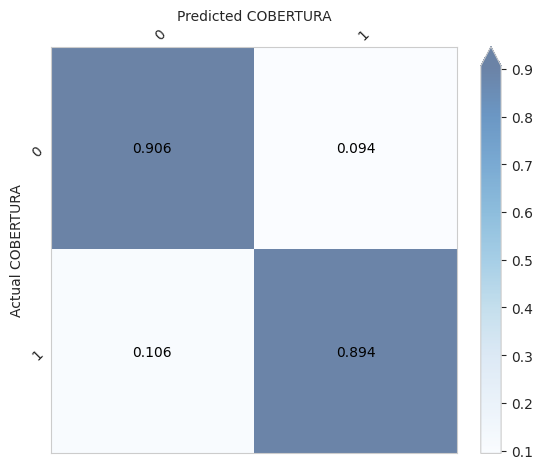

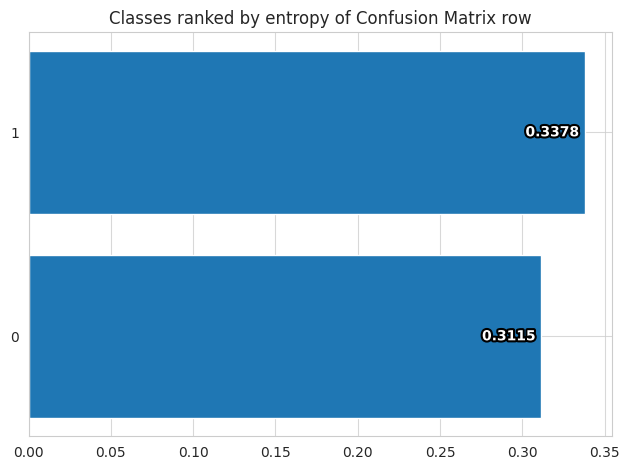

In [ ]:
# Visualizes confusion matrix, which gives an overview of classifier performance
# for each class.
from ludwig.visualize import confusion_matrix

confusion_matrix(
  [test_stats],
  model.training_set_metadata,
  'class',
  top_n_classes=[5],
  model_names=[''],
  normalize=True,
)

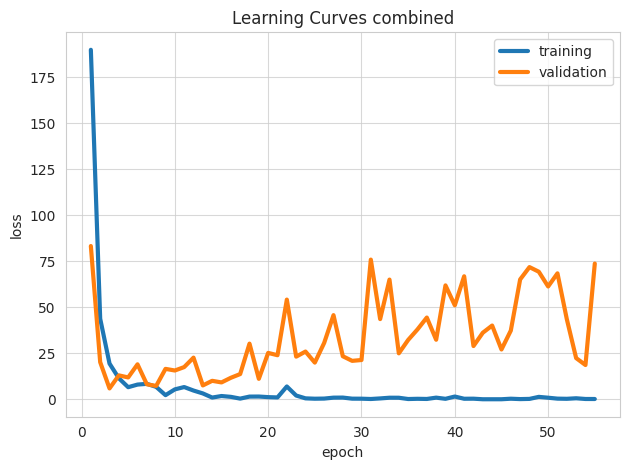

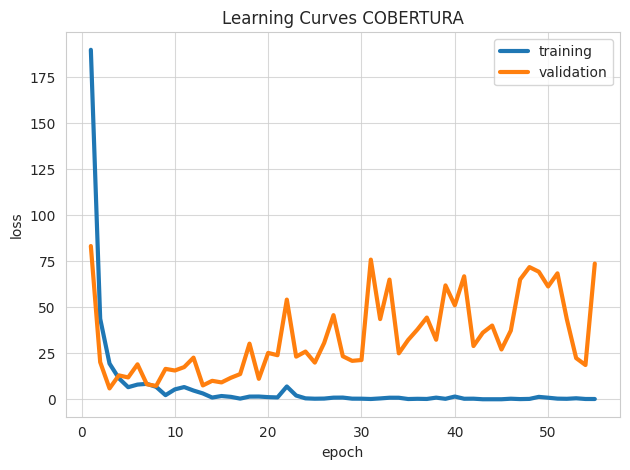

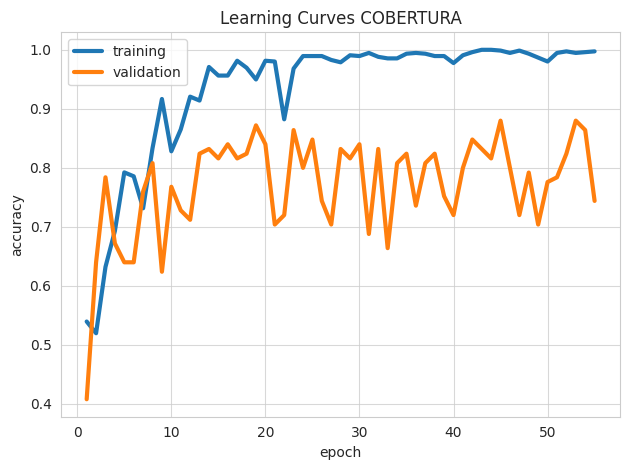

In [ ]:
# Visualizes learning curves, which show how performance metrics changed over
# time during training.
from ludwig.visualize import learning_curves

learning_curves(train_stats, output_feature_name='class')